In [1]:
import sys
sys.path.insert(0, '..')
from utils import load_npy_image, load_tiff_image
import os
import matplotlib.pyplot as plt
import numpy as np
from preprocess_save_patches_Amazon import mask_no_considered
from skimage.util.shape import view_as_windows
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import cv2
import seaborn as sns

In [2]:
root_path = '/media/thimabru/ssd/TCC/imagens_satelite_dataset/cut_img_66_new'
# Load images --------------------------------------------------------------
img_t1_path = 'cut_raster_2018_ok.tif'
img_t2_path = 'cut_raster_2019_ok.tif'
img_t1 = load_tiff_image(os.path.join(root_path, img_t1_path))
print(type(img_t1))
img_t2 = load_tiff_image(os.path.join(root_path, img_t2_path))
print(img_t1.shape)
print(img_t2.shape)

/media/thimabru/ssd/TCC/imagens_satelite_dataset/cut_img_66_new/cut_raster_2018_ok.tif
<class 'numpy.ndarray'>
/media/thimabru/ssd/TCC/imagens_satelite_dataset/cut_img_66_new/cut_raster_2019_ok.tif
(7, 5222, 5043)
(7, 5222, 5043)


In [3]:
# Convert shape from C x H x W --> H x W x C
# Convert from float32 to uint8
img_t1 = img_t1.transpose((1, 2, 0))
img_t2 = img_t2.transpose((1, 2, 0))
input_image = np.concatenate((img_t1, img_t2), axis=-1)
# img_train_normalized = normalization(img_train)
print('Image 7 bands')
print(img_t1.shape)
print(img_t1.dtype)
print(img_t2.shape)
print(img_t2.dtype)
print(input_image.shape)
print(input_image.dtype)
print(img_t1.min(), img_t1.max())

Image 7 bands
(5222, 5043, 7)
uint16
(5222, 5043, 7)
uint16
(5222, 5043, 14)
uint16
4058 65535


In [4]:
img_t1_bgr = (img_t1[:, :, 1:4]).astype(np.uint8)
img_t1_rgb = img_t1_bgr[:, :, ::-1]
print(img_t1_rgb.min(), img_t1_rgb.max())

0 255


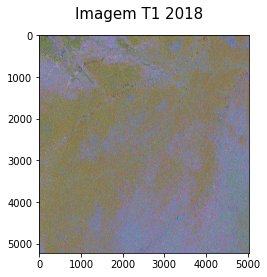

In [5]:
fig = plt.figure()
fig.suptitle('Imagem T1 2018', fontsize=15)
plt.imshow(img_t1_rgb)

In [4]:
def normalization(image, norm_type=1):
    image_reshaped = image.reshape((image.shape[0] * image.shape[1]),
                                   image.shape[2])
    if(norm_type == 1):
        scaler = StandardScaler()
    if(norm_type == 2):
        scaler = MinMaxScaler(feature_range=(0, 1))
    if(norm_type == 3):
        scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(image_reshaped)
    scaler2 = scaler
#     print(scaler.get_params())
#     print(scaler.mean_)
    # image_normalized = scaler2.fit_transform(image_reshaped)
    image_normalized = scaler2.transform(image_reshaped)
    image_normalized1 = image_normalized.reshape(image.shape[0], image.shape[1], image.shape[2])
    return scaler, image_normalized1

/home/thimabru/.virtualenvs/base/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint16 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


[[0.81479043 0.82484585 0.83720599 ... 0.83704611 0.83128501 0.86776882]
 [0.84854445 0.85572522 0.85224351 ... 0.87288054 0.8674987  0.87321746]
 [0.87278697 0.86759488 0.85818678 ... 0.88492606 0.89567054 0.86911994]
 ...
 [0.84821736 0.863158   0.85170963 ... 0.89489388 0.90203808 0.91027879]
 [0.84391352 0.86008872 0.89053474 ... 0.91226556 0.90922069 0.90939499]
 [0.8148079  0.82651699 0.84845588 ... 0.89961513 0.93668113 0.90204194]]
-1.0 1.0
-4.1386104130244465 2.573731797463978
(5222, 5043)


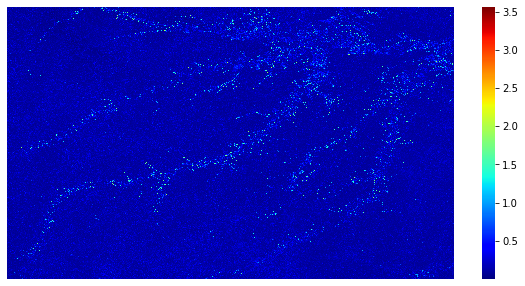

In [5]:
#%% ************ CVA ************
# image_t1 = img_t1
# image_t2 = img_t2

_, image_t1 = normalization(img_t1, norm_type=2)
_, image_t2 = normalization(img_t2, norm_type=2)

import math
blue_t1 = image_t1[:,:,1]
red_t1 = image_t1[:,:,3]
nir_t1 = image_t1[:,:,4]
swir_t1 = image_t1[:,:,5]

blue_t2 = image_t2[:,:,1]
red_t2 = image_t2[:,:,3]
nir_t2 = image_t2[:,:,4]
swir_t2 = image_t2[:,:,5]

# NDVI and BI index
ndvi1 = (nir_t1-red_t1)/(nir_t1+red_t1)
print(ndvi1)
bi1 = (swir_t1+red_t1)-(nir_t1+blue_t1)/(swir_t1+red_t1)+(nir_t1+blue_t1)

ndvi2 = (nir_t2-red_t2)/(nir_t2+red_t2)
bi2 = (swir_t2+red_t2)-(nir_t2+blue_t2)/(swir_t2+red_t2)+(nir_t2+blue_t2)
print(np.min(ndvi1), np.max(ndvi1))
print(np.min(bi1), np.max(bi1))

# Calculating the change:
S =(ndvi2-ndvi1)**2+(bi2-bi1)**2
S1 = np.sqrt(S)

print(S1.shape)
plt.figure(figsize=(10,5))
ax = sns.heatmap(S1, cmap="jet")
ax.set_axis_off()


In [6]:
print(S1)

[[0.05052957 0.22795799 0.12770918 ... 0.11725523 0.12775502 0.09074753]
 [0.05790814 0.0523224  0.07752611 ... 0.09514952 0.08972882 0.10546053]
 [0.10864287 0.07852521 0.07059766 ... 0.2566656  0.12728997 0.11117257]
 ...
 [0.10570256 0.11108417 0.08828615 ... 0.08223606 0.08144878 0.10785038]
 [0.06327307 0.05434242 0.16813247 ... 0.07996668 0.13376282 0.10638429]
 [0.12115425 0.05752772 0.07928024 ... 0.14772427 0.12126914 0.11162829]]


In [7]:
print(np.min(S1), np.max(S1))

0.00012481831678690442 3.563828751256899


In [8]:
# S1_normed = np.copy(S1)
# th = 1500
# S1_normed[S1 >= th] = 1
# S1_normed[S1 < th] = 0
# print(S1_normed)
# plt.imshow(S1_normed)
# plt.show()

In [9]:
# plt.figure(figsize=(10,5))
# ax = sns.heatmap(S1_normed, cmap="jet")
# ax.set_axis_off()

/media/thimabru/ssd/TCC/imagens_satelite_dataset/cut_img_66_new/cut_ref_2019_ok.tif
Image reference shape: (5222, 5043)


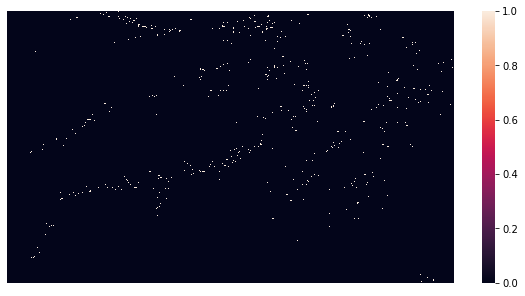

In [10]:
'''
    0 --> No deforastation
    1 --> Deforastation
'''
image_ref = load_tiff_image(os.path.join(root_path,
                                        'cut_ref_2019_ok.tif'))
# Clip to fit tiles of your specific image
# image_ref = image_ref[:6100, :6600]
# image_ref[img_mask_ref == -99] = -1
print(f"Image reference shape: {image_ref.shape}")
plt.figure(figsize=(10,5))
ax = sns.heatmap(image_ref)
ax.set_axis_off()

In [11]:
print(S1)

[[0.05052957 0.22795799 0.12770918 ... 0.11725523 0.12775502 0.09074753]
 [0.05790814 0.0523224  0.07752611 ... 0.09514952 0.08972882 0.10546053]
 [0.10864287 0.07852521 0.07059766 ... 0.2566656  0.12728997 0.11117257]
 ...
 [0.10570256 0.11108417 0.08828615 ... 0.08223606 0.08144878 0.10785038]
 [0.06327307 0.05434242 0.16813247 ... 0.07996668 0.13376282 0.10638429]
 [0.12115425 0.05752772 0.07928024 ... 0.14772427 0.12126914 0.11162829]]


In [22]:
S1_normed = np.copy(S1)
th = 1.1
S1_normed[S1 >= th] = 1
S1_normed[S1 < th] = 0
print(S1_normed)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


CVA pixels: {0.0: 26199617, 1.0: 134929}
Image ref pixels: {0.0: 26224544, 1.0: 110002}


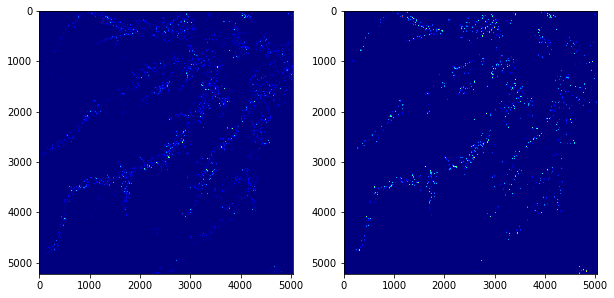

In [23]:
unique, counts = np.unique(S1_normed, return_counts=True)
counts_dict = dict(zip(unique, counts))
print(f'CVA pixels: {counts_dict}')

unique, counts = np.unique(image_ref, return_counts=True)
counts_dict = dict(zip(unique, counts))
print(f'Image ref pixels: {counts_dict}')
    
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].imshow(S1_normed, cmap='jet')
axes[1].imshow(image_ref, cmap='jet')
plt.show()

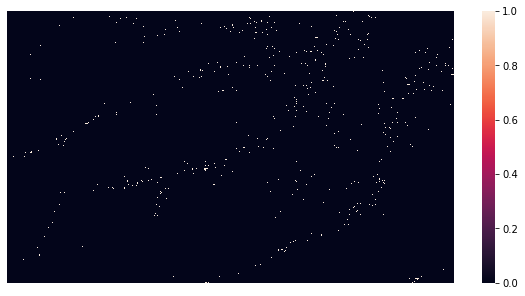

In [17]:
# optimal_idx = np.argmax(tpr - fpr)
# optimal_threshold = thresholds[optimal_idx]

plt.figure(figsize=(10,5))
ax = sns.heatmap(S1_normed)
ax.set_axis_off()

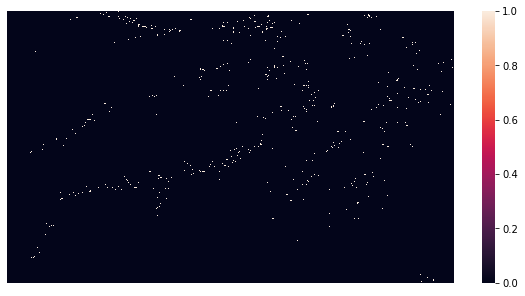

In [24]:
plt.figure(figsize=(10,5))
ax = sns.heatmap(image_ref)
ax.set_axis_off()